In [1]:
import numpy as np
import scipy.io as sio
import cvxpy as cvx
from scipy.stats import entropy
%matplotlib inline
import matplotlib.pyplot as plt

# Dual Gradient Ascent (or Descent)

This notebook walks through an example illustrating dual gradient ascent.

Suppose we have a problem where we can take one of five actions, and get a reward based on the action we take (defined as the q vector). Then it's clear that we should take the action associated with the maximum reward.

In [2]:
# Basic unconstrained problem; q is vector of rewards for taking actions a1, a2, a3, a4, a5
# p is our optimal probability distribution over actions

q = np.array([1,2,3,4,5])
p = cvx.Variable(5)
e_reward = q.T * p
obj = cvx.Maximize(e_reward)
constraints = [p >= 0, cvx.sum_entries(p) == 1]

prob = cvx.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print "status:", prob.status
print "optimal value", round(prob.value, 3)
print "optimal var", [round(p, 3) for p in p.value]

status: optimal
optimal value 5.0
optimal var [0.0, 0.0, 0.0, 0.0, 1.0]


Now suppose that we also have a secondary objective in addition to maximizing the reward: maximize the entropy. This corresponds to our controller trying to maximize both the amount of randomness in our action and the reward. We solve this via an iterative procedure (dual gradient ascent) where we alternate between two steps. Here, we dualize the constraint of $p$ being a probability distribution ($1^Tp = 1$).

(note that dual ascent is not necessary for solving this problem since we can actually directly solve the optimal value of the dual function).

Here is the algorithm: Start with some initial dual variable $\nu$ which represents how much we are penalized for violating the constraint.


Alternate between two steps:
1. Solve for the distribution $p$ that maximizes $p = \arg \max_{p} L(p, \lambda) = \arg \max_{p} q^T p + H(p) + \nu (1^T p - 1)$
2. Take a gradient step on $\nu$. This corresponds to how much we are violating the constraint.

In [3]:
def dual_ascent_entropy(q, entropy_weight = 1, init_nu = 1.0,
                        iterations = 200, print_every = None, step_size = 2e-2):
    nus = []
    total_prob = []
    nu = init_nu
    p = np.zeros(q.size)
    for i in range(iterations):
        
        # solving the problem min_ nu max_ p   L(x, nu)
        # for a fixed nu, we can solve for p by setting the gradient to 0
        p = np.exp(q / entropy_weight + nu - 1)
        if print_every and i % print_every == 0:
            print("*" * 10 + " iteration: {} ".format(i) + "*" * 10)
            print("p: {}".format([round(x, 3) for x in list(p)]))
            print("sum p: {}".format(round(np.sum(p), 3)))
        
        # minimizing over nu, gradient is constraint violation!
        gradient = np.sum(p) - 1
        nu = nu - step_size * gradient
        if print_every and i % print_every == 0:
            print("gradient: {}".format(round(gradient, 3)))
            print("nu: {}".format(round(nu, 3)))
        
        total_prob.append(np.sum(p))
        nus.append(nu)
    print("final p: {}".format([round(x, 3) for x in list(p)]))
    return total_prob, nus
        

In [4]:
q = np.array([1,2,3,4,5])
iterations = 300
total_prob, nus = dual_ascent_entropy(q, iterations = iterations, print_every=50)


********** iteration: 0 **********
p: [2.718, 7.389, 20.086, 54.598, 148.413]
sum p: 233.204
gradient: 232.204
nu: -3.644
********** iteration: 50 **********
p: [0.015, 0.04, 0.108, 0.294, 0.8]
sum p: 1.257
gradient: 0.257
nu: -4.228
********** iteration: 100 **********
p: [0.013, 0.034, 0.093, 0.253, 0.688]
sum p: 1.08
gradient: 0.08
nu: -4.376
********** iteration: 150 **********
p: [0.012, 0.033, 0.089, 0.241, 0.654]
sum p: 1.028
gradient: 0.028
nu: -4.425
********** iteration: 200 **********
p: [0.012, 0.032, 0.087, 0.236, 0.643]
sum p: 1.01
gradient: 0.01
nu: -4.442
********** iteration: 250 **********
p: [0.012, 0.032, 0.086, 0.235, 0.639]
sum p: 1.004
gradient: 0.004
nu: -4.448
final p: [0.012, 0.032, 0.086, 0.234, 0.637]


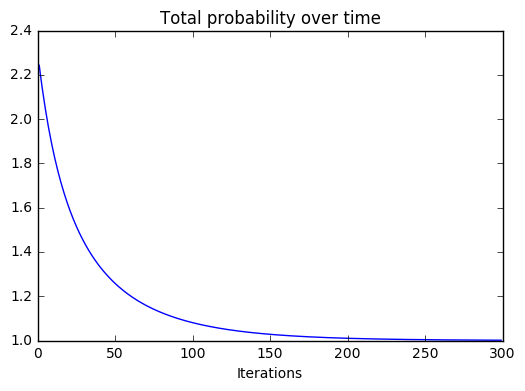

In [5]:
plt.title("Total probability over time")
plt.xlabel("Iterations")
plt.plot(range(iterations)[1:], total_prob[1:])
plt.show()

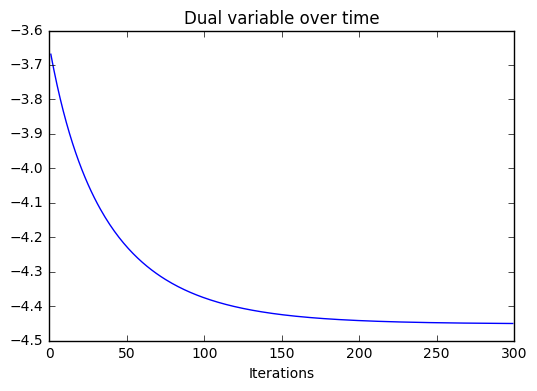

In [6]:
plt.title("Dual variable over time")
plt.xlabel("Iterations")
plt.plot(range(iterations)[1:], nus[1:])
plt.show()

As a check we get the same solution in cvxpy.

In [7]:
# Entropy constrained problem

q = np.array([1,2,3,4,5])
p = cvx.Variable(5)
e_reward = q.T * p
entropy_weight = 1
entropy = cvx.sum_entries(cvx.entr(p))
obj = cvx.Maximize(e_reward + entropy_weight * entropy)
constraints = [p >= 0, cvx.sum_entries(p) == 1]

prob = cvx.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print "status:", prob.status
print "optimal value", round(prob.value, 3)
print "optimal var", [round(p, 3) for p in p.value]

status: optimal
optimal value 5.452
optimal var [0.012, 0.032, 0.086, 0.234, 0.636]
